# Filter analysis of Convolutional Layers

This notebook investigates features were learned by filters in the convolutional layers in a conv. network. Especially we are interested in the features learned by filters that show a higher average activity for inputs of a certain class. In this case the network was trained on 128 electrode EEG data to discriminate between 4 classes (right hand, left hand, rest, right foot).

To find the fiters of interest the data it was trained on (1720 trials / 430 per class) was run through the network and the average activity over all units in a filter over all inputs for a certain class was recorded. The mean activity of the filters regarding a single class was then compared with the average activity for the remaining classes to find the on average most active filters for a certain class.

The 200 trials that invoked the highest response in a unit of a filter (top 46% of class trials) were determined and the signal window that was responsible for activity in that unit (receptive field of the unit on the total input) was recorded. Several features are then extracted from those windows and their distribution is compared to a baseline of (randomly) sampled control inputs also belonging to one of the 4 classes.

The deeper the layer in the convolutional network, the bigger the receptive field of its units and more complex characteristic features are expected.

In [1]:
import os
cl = 0
if "EEGCLASS" in os.environ:
    cl = int(os.environ['EEGCLASS'])-1
n_class_inputs = 50
max_baseline_inputs = 2000 # Number of signal windows used for baseline
wins_per_input = 1
freq_bands = [[0,4],[4,7],[7,14],[15,30],[30,100]]

In [2]:
import numpy as np
import scipy
import random

from braindecode.veganlasagne.layer_util import print_layers
import braindecode.paper.plot

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 5005)


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
import convvisual.receptive_field.receptive_field as receptive_field
import convvisual.analysis.analysis as analysis
import convvisual.analysis.utils as utils
import convvisual.analysis.plot as plot

In [5]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'

In [6]:
rng = RandomState(98787)

In [8]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits50_nFilters05'))
n_chans = RF_Data.n_chans
sampling_rate = RF_Data.sampling_rate
sensor_names = RF_Data.sensor_names

# Layer 03

Analysis of filters in Layer 03

In [8]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits50_nFilters05'),3,cl)

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [13 20 22 18  2]


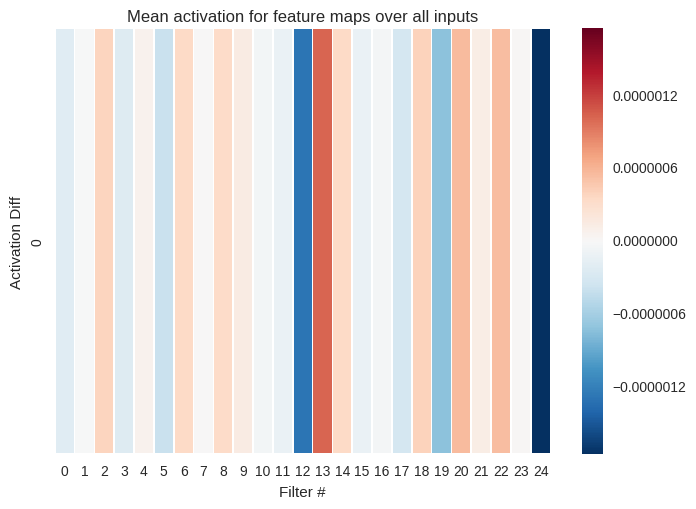

In [9]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [10]:
filt = 0

In [11]:
X_RF_cropped = utils.get_RF(RF_Result,filt,1)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

sensor_names_one_chan = ['N/A' for entry in sensor_names]
feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names_one_chan,frequencies],
                                    'FFTc':[sensor_names_one_chan,frequencies],
                                    'Phase':[sensor_names_one_chan,frequencies[1:]],
                                    'Phasec':[sensor_names_one_chan,frequencies[1:]],
                                    'Mean':[sensor_names_one_chan],
                                    'Meanc':[sensor_names_one_chan],
                                    'Power':[sensor_names_one_chan]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

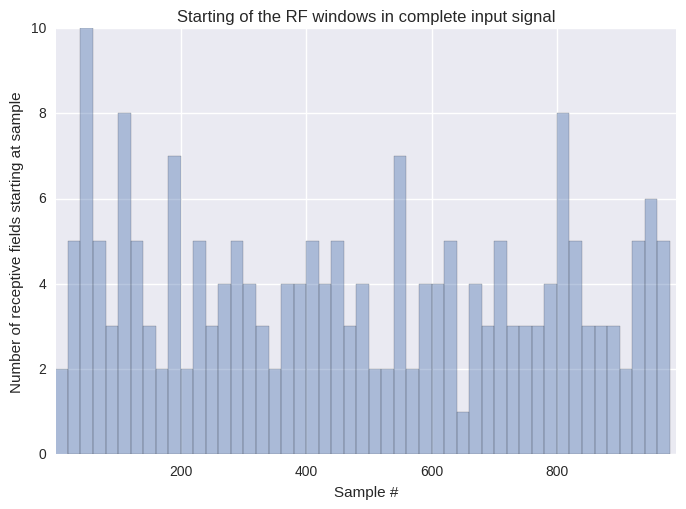

In [12]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Channels of the Receptive Field
In Layer 03 the receptive field is still channel specific. Therefore it could be interesting to see from which channel the most maximizing signal windows originate

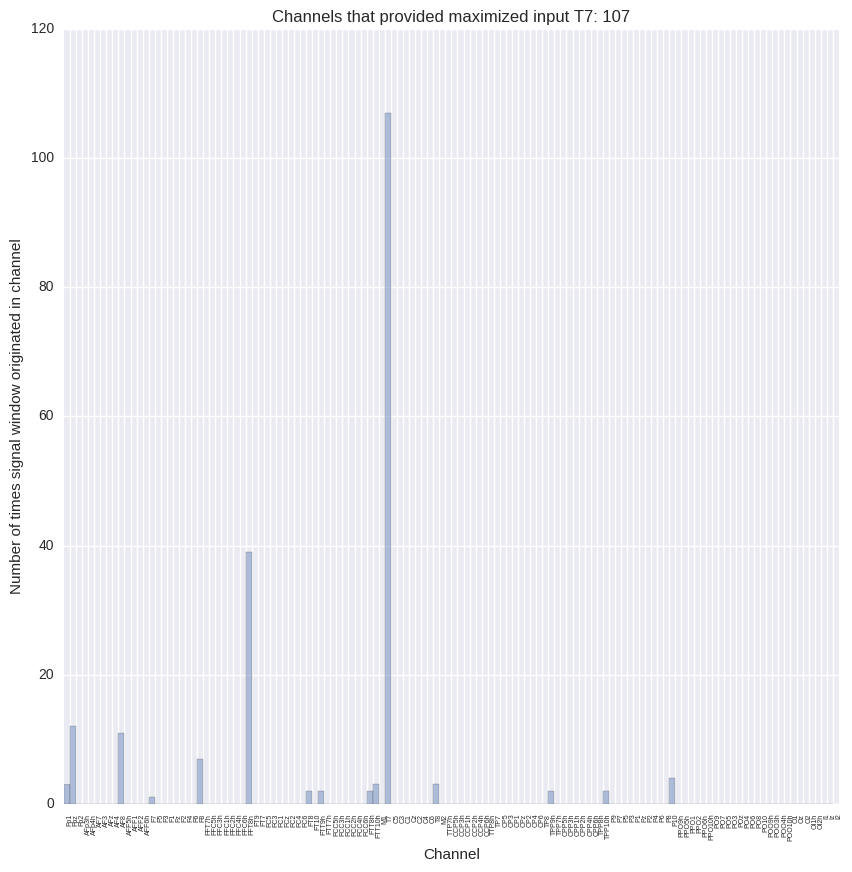

In [13]:
plot.plot_channels(RF_Result,sensor_names,filt,n_chans)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

There are no channel specific features in L03, because the features are extracted for the one channel in the receptive field.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name
<b>Power</b>: Total variance of signal
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [14]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.992500  p 0.000000  : Power N/A
Score 0.982000  p 0.000000  : FFT N/A 75.0
Score 0.971000  p 0.000000  : FFT N/A 50.0
Score 0.964000  p 0.000000  : FFT N/A 100.0
Score 0.881000  p 0.000000  : FFT N/A 25.0
Score 0.775000  p 0.000000  : Meanc N/A
Score 0.726000  p 0.000000  : FFTc N/A 25.0
Score 0.696000  p 0.000000  : Phase N/A 25.0
Score 0.629000  p 0.000000  : Phase N/A 75.0
Score 0.493000  p 0.000000  : Phase N/A 100.0
Score 0.480000  p 0.000000  : Phase N/A 50.0
Score 0.283000  p 0.000000  : Phasec N/A 25.0
Score 0.171500  p 0.006340  : Mean N/A
Score 0.136500  p 0.052236  : FFTc N/A 0.0
Score 0.122000  p 0.108735  : FFT N/A 0.0


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

(100, 15) (2000, 15)


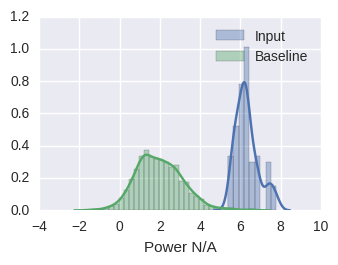

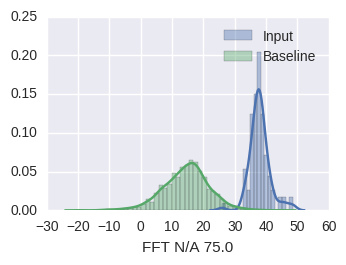

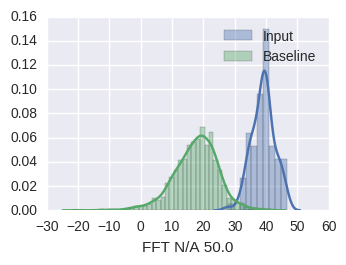

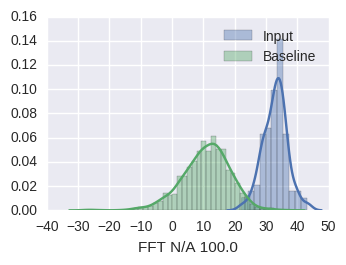

In [15]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

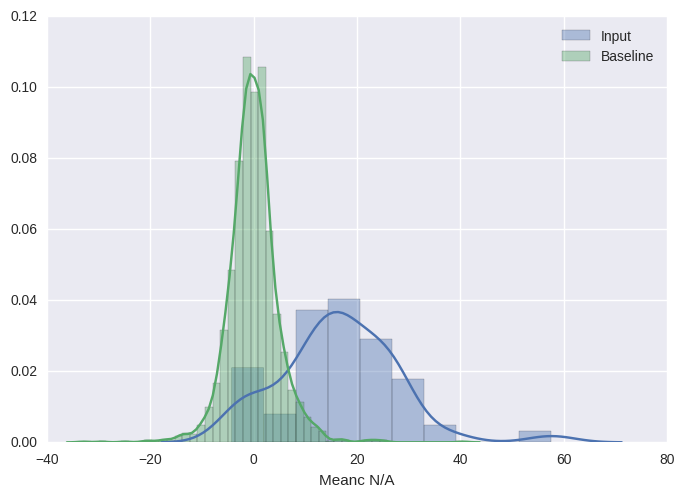

In [16]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows.  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [17]:
print index_labels[sort_mean_diff[:10]]

[['Power', [0]] ['FFT', [0, 3]] ['FFT', [0, 2]] ['FFT', [0, 4]]
 ['FFT', [0, 1]] ['Meanc', [0]] ['FFTc', [0, 1]] ['Phase', [0, 0]]
 ['Phase', [0, 2]] ['Phase', [0, 3]]]


In [18]:
print X_baseline.shape

(2000, 1, 10)


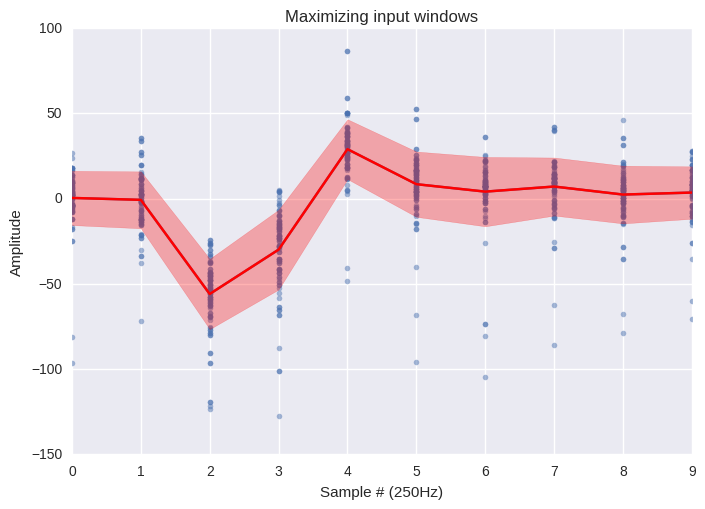

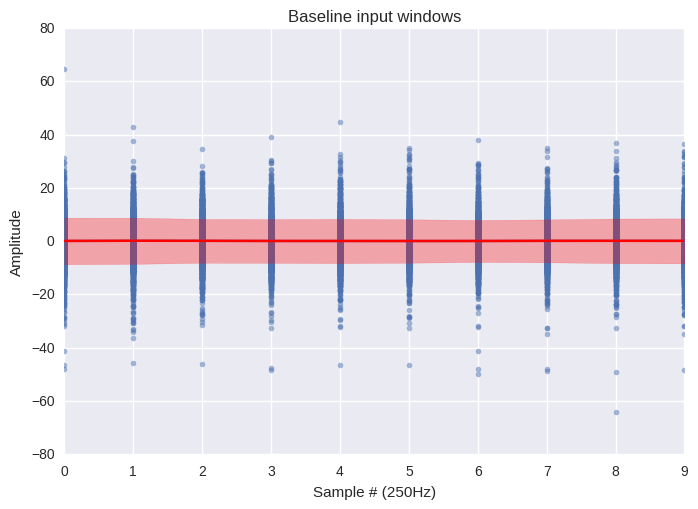

In [19]:
plot.plot_channel_avg(X_RF_cropped,0,'Maximizing input windows')
plot.plot_channel_avg(X_baseline,0,'Baseline input windows')

# Layer 04

Analysis of filters in Layer 04

In [20]:
del RF_Result

In [9]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits50_nFilters05'),4,cl)

### Filter activation

Max filters:  [12 24 13 20 14]


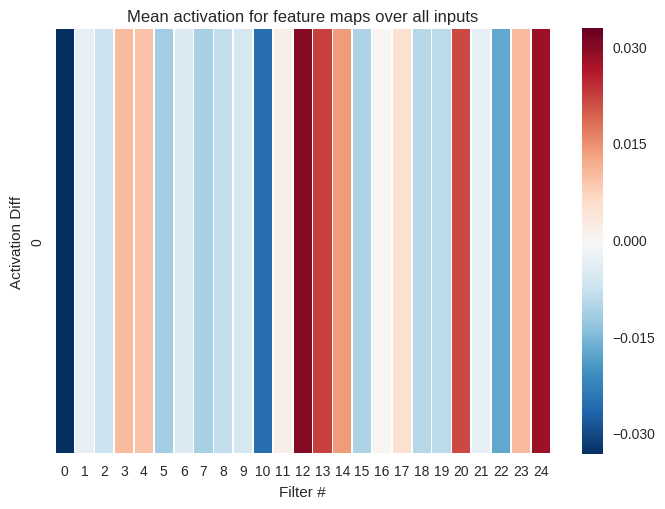

In [10]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [11]:
filt = 0

In [12]:
X_RF_cropped = utils.get_RF(RF_Result,filt,128)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2]

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Power':[sensor_names]})

In [47]:
FFT_bands_diff,Phase_bands_class,(FFT_KS_bands,Phase_KS_bands) = utils.get_FFT_Phase_band_means_KS_diff(X_baseline,X_RF_cropped,sampling_rate,frequencies,freq_bands)

### Receptive field starting sample

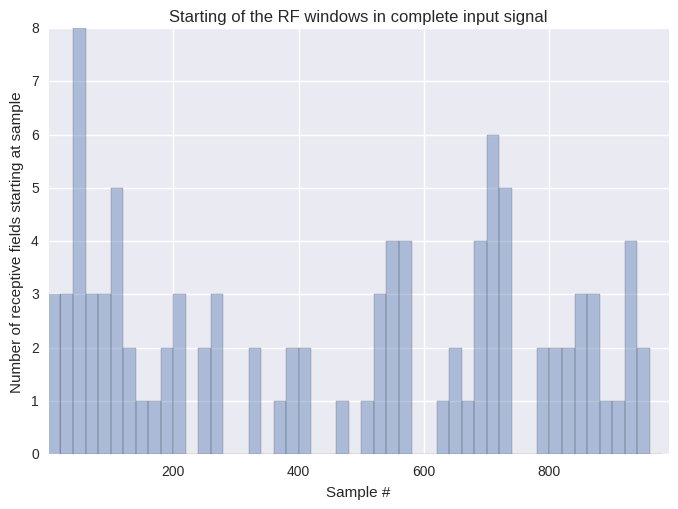

In [21]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Most differentiating Features

In [22]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.474637  p 0.000000  : Phase FCz 75.0
Score 0.472291  p 0.000001  : FFT FT8 75.0
Score 0.459777  p 0.000002  : Phase FC2 75.0
Score 0.458659  p 0.000002  : FFT PPO1 75.0
Score 0.456872  p 0.000003  : Phase FCC2h 75.0
Score 0.455642  p 0.000003  : Phase FC6 75.0
Score 0.451173  p 0.000004  : Power FT8
Score 0.445140  p 0.000008  : FFT FTT10h 25.0
Score 0.439441  p 0.000013  : FFT TPP10h 50.0
Score 0.437989  p 0.000014  : FFT PPO10h 50.0
Score 0.427598  p 0.000036  : Phase FFC2h 75.0
Score 0.426369  p 0.000040  : Power FTT10h
Score 0.422793  p 0.000054  : FFT P8 50.0
Score 0.422570  p 0.000055  : Phase FCC1h 75.0
Score 0.421899  p 0.000059  : FFT FTT10h 75.0
Score 0.420670  p 0.000065  : FFT CPP4h 100.0
Score 0.416536  p 0.000092  : Phase FFC1h 75.0
Score 0.416201  p 0.000095  : FFT CPP5h 75.0
Score 0.412514  p 0.000129  : FFT T8 50.0
Score 0.412291  p 0.000132  : FFT CCP2h 50.0


##### Feature distributions

(50, 1920) (1790, 1920)


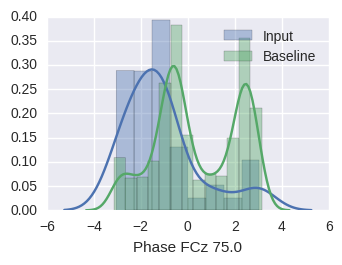

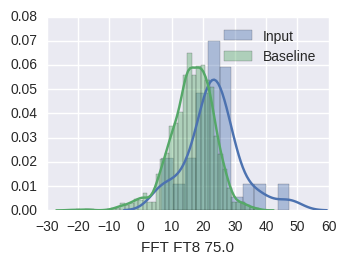

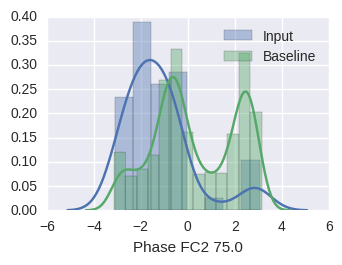

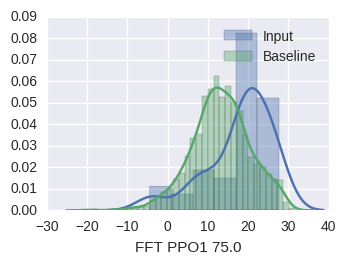

In [23]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

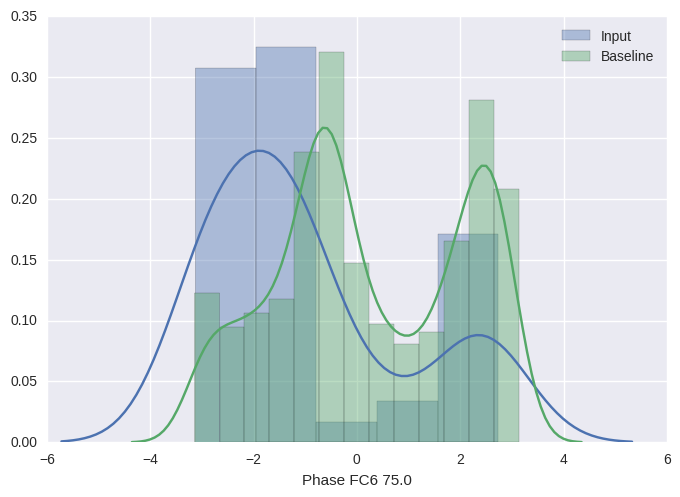

In [24]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window

In [25]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [36, 2]] ['FFT', [40, 3]] ['Phase', [37, 2]] ['FFT', [103, 3]]
 ['Phase', [47, 2]] ['Phase', [39, 2]] ['Power', [40]] ['FFT', [51, 1]]
 ['FFT', [89, 2]] ['FFT', [106, 2]]]


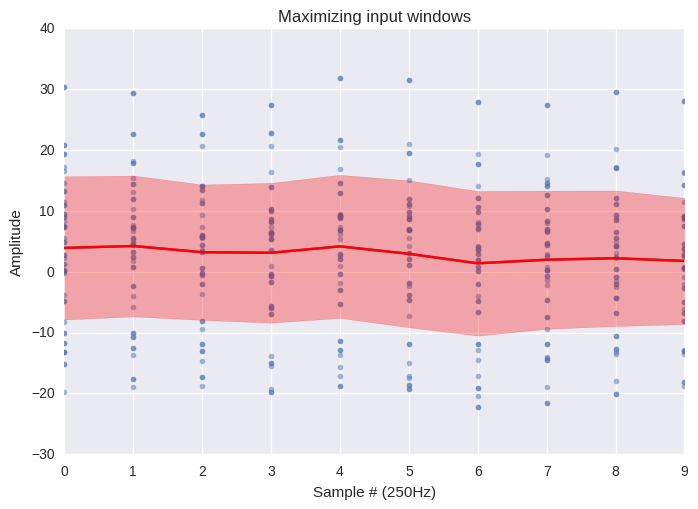

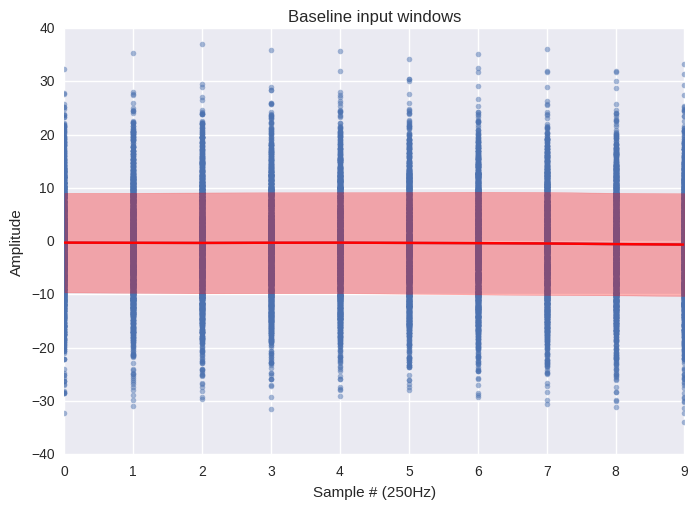

In [28]:
ch = index_labels[sort_mean_diff[:10]][0][1][0]
plot.plot_channel_avg(X_RF_cropped,ch,'Maximizing input windows')
plt.show()
plot.plot_channel_avg(X_baseline,ch,'Baseline input windows')
plt.show()

### FFT Topology Plots
1. Band Power difference<br>
Difference of band power between class and baseline inputs
2. Band Power KS Score<br>
Mean KS score of bands in electrodes

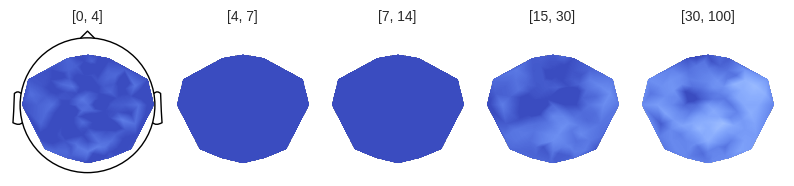

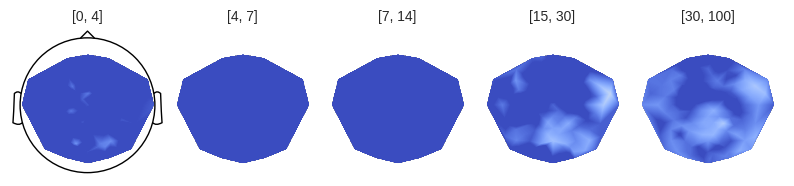

In [48]:
plot.plot_scalp_grid_bands_mean(FFT_bands_diff,sensor_names,freq_bands,vmin=0,vmax=1,scale_per_row=False)
plot.plot_scalp_grid_bands_mean(FFT_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

### Phase Topology Plots
1. Variance phase in band
2. Band Phase KS Score

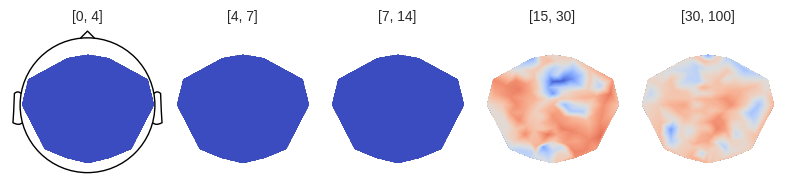

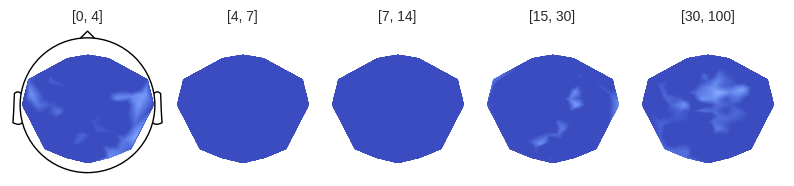

In [49]:
plot.plot_scalp_grid_bands_mean(Phase_bands_class,sensor_names,freq_bands,vmin=0,vmax=1,scale_per_row=False)
plot.plot_scalp_grid_bands_mean(Phase_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

In [46]:
Phase_bands_class>0

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, Fal

# Layer 10

Analysis of filters in Layer 10

In [34]:
del RF_Result

In [35]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits200_nFilters5'),10,cl)

### Filter activation

Max filters:  [25 49 16 27 11]


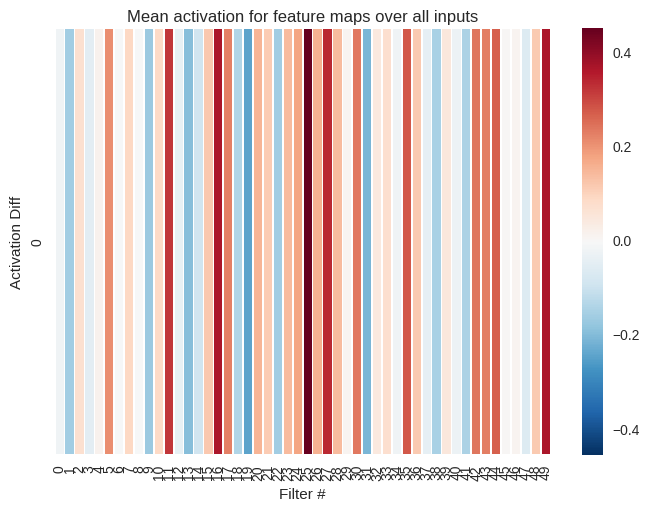

In [36]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [37]:
filt = 0

In [38]:
X_RF_cropped = utils.get_RF(RF_Result,filt,128)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2]

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Power':[sensor_names]})

In [18]:
FFT_bands_diff,Phase_bands_class,(FFT_KS_bands,Phase_KS_bands) = utils.get_FFT_Phase_band_means_KS_diff(X_baseline,X_RF_cropped,sampling_rate,frequencies,freq_bands)

NameError: global name 'Phase_base_mean' is not defined

### Receptive field starting sample

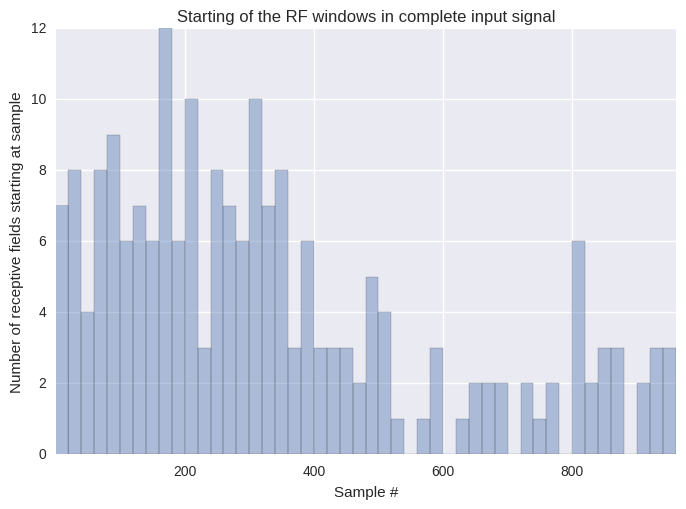

In [40]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Most differentiating Features

In [41]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.581173  p 0.000000  : FFT FCC4h 12.8205128205
Score 0.511508  p 0.000000  : Phase CP5 12.8205128205
Score 0.488436  p 0.000000  : Phase CCP5h 12.8205128205
Score 0.473799  p 0.000000  : Phase TTP7h 12.8205128205
Score 0.455587  p 0.000000  : FFT FC4 12.8205128205
Score 0.453743  p 0.000000  : FFT FCC2h 12.8205128205
Score 0.448212  p 0.000000  : Phase C5 12.8205128205
Score 0.446257  p 0.000000  : Phase TP7 12.8205128205
Score 0.440838  p 0.000000  : Phase FCC4h 12.8205128205
Score 0.438101  p 0.000000  : Phase C4 12.8205128205
Score 0.434078  p 0.000000  : FFT FC2 12.8205128205
Score 0.430168  p 0.000000  : FFT C2 12.8205128205
Score 0.426927  p 0.000000  : Phase TPP7h 12.8205128205
Score 0.424078  p 0.000000  : Phase FC4 12.8205128205
Score 0.419944  p 0.000000  : Phase P7 12.8205128205
Score 0.418492  p 0.000000  : Power FCC4h
Score 0.396425  p 0.000000  : Phase C2 12.8205128205
Score 0.392961  p 0.000000  : Phase FT7 12.8205128205
Score 0.387430  p 0.000000  : Phase CCP4h 1

##### Feature distributions

(100, 7296) (1790, 7296)


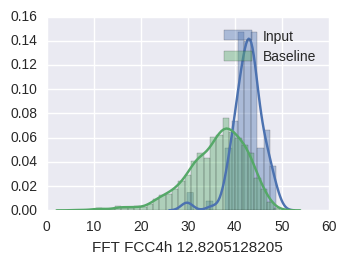

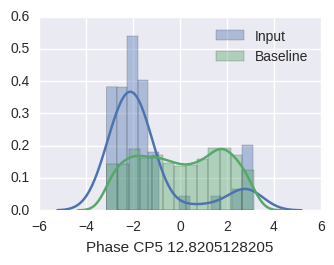

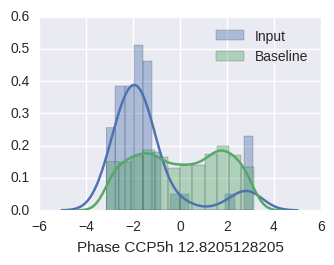

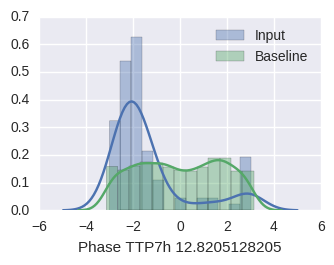

In [42]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

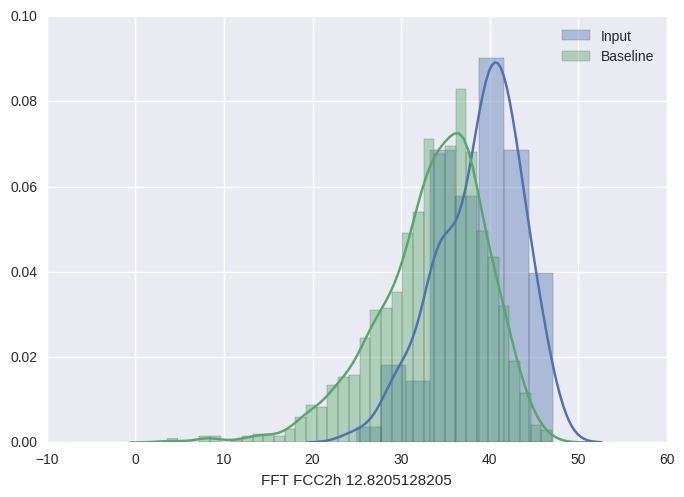

In [43]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window

In [44]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [48, 2]] ['Phase', [72, 1]] ['Phase', [64, 1]] ['Phase', [63, 1]]
 ['FFT', [38, 2]] ['FFT', [47, 2]] ['Phase', [54, 1]] ['Phase', [71, 1]]
 ['Phase', [48, 1]] ['Phase', [59, 1]]]


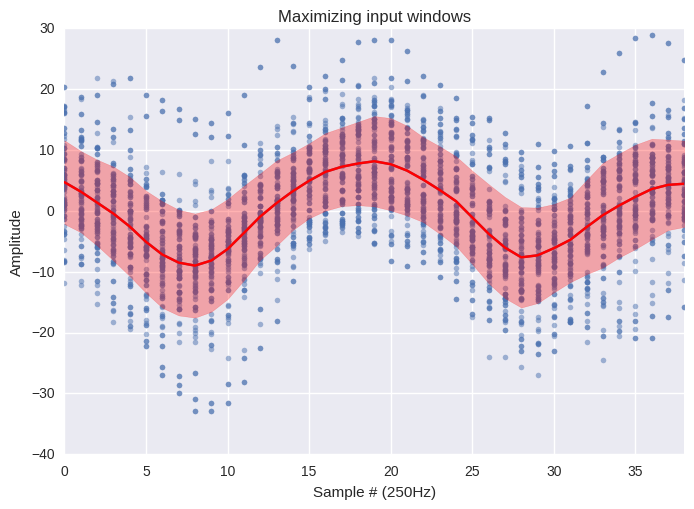

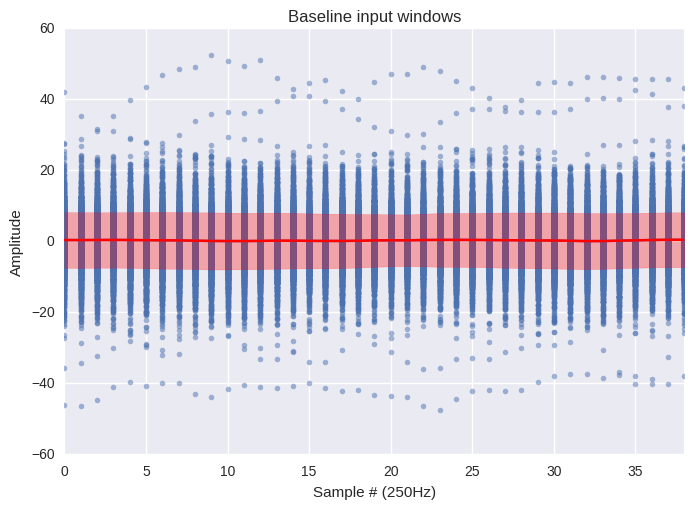

In [45]:
ch = index_labels[sort_mean_diff[:10]][0][1][0]
plot.plot_channel_avg(X_RF_cropped,ch,'Maximizing input windows')
plot.plot_channel_avg(X_baseline,ch,'Baseline input windows')

### FFT Topology Plots
1. Band Power difference
2. Band Power KS Score

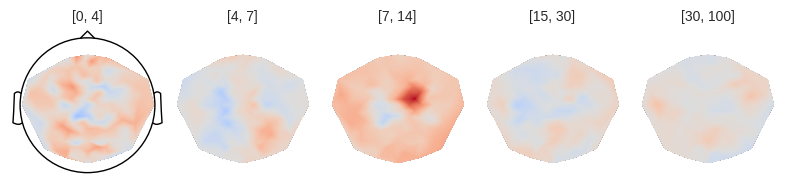

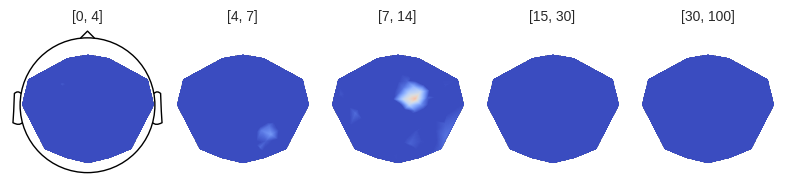

In [46]:
plot.plot_scalp_grid_bands_mean(FFT_bands_diff,sensor_names,freq_bands)
plot.plot_scalp_grid_bands_mean(FFT_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

### Phase Topology Plots
1. Variance phase in band
2. Band Phase KS Score

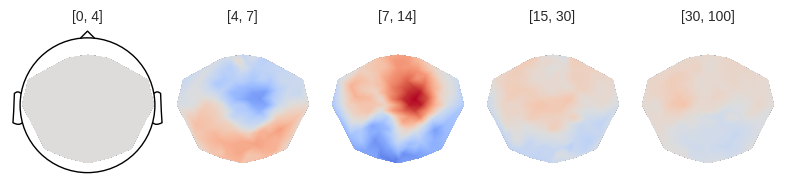

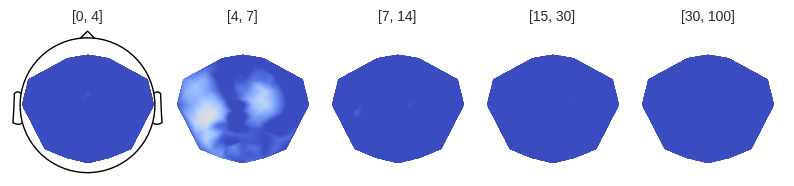

In [47]:
plot.plot_scalp_grid_bands_mean(Phase_bands_class,sensor_names,freq_bands,scale_per_row=True)
plot.plot_scalp_grid_bands_mean(Phase_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

# Layer 16

Analysis of filters in Layer 16

In [48]:
del RF_Result

In [58]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits50_nFilters05'),16,cl)

### Filter activation

Max filters:  [70 62 76 55 88]


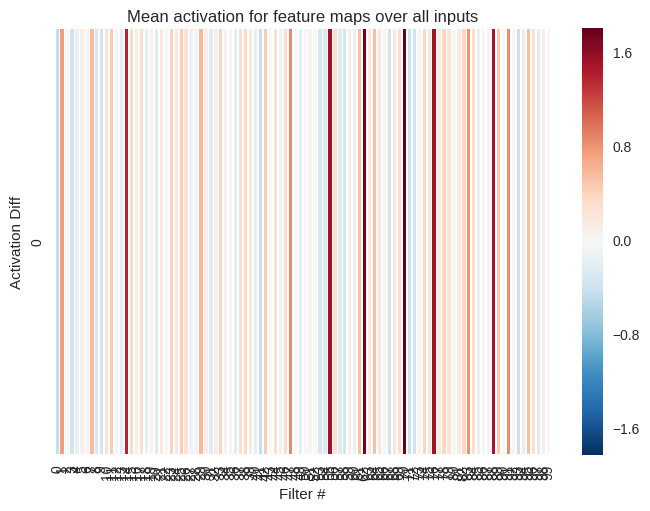

In [59]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [60]:
filt = 0

In [61]:
X_RF_cropped = utils.get_RF(RF_Result,filt,128)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2]

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Power':[sensor_names]})

In [62]:
FFT_bands_diff,Phase_bands_class,(FFT_KS_bands,Phase_KS_bands) = utils.get_FFT_Phase_band_means_KS_diff(X_baseline,X_RF_cropped,sampling_rate,frequencies,freq_bands)

### Receptive field starting sample

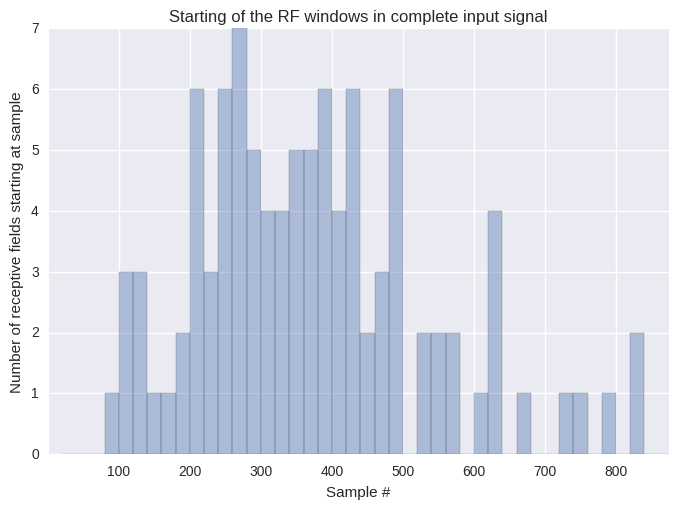

In [63]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Most differentiating Features

In [64]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.779553  p 0.000000  : Phase FC4 11.9047619048
Score 0.756648  p 0.000000  : Phase FCC4h 11.9047619048
Score 0.652402  p 0.000000  : Phase C4 11.9047619048
Score 0.608045  p 0.000000  : Phase FFC4h 11.9047619048
Score 0.603017  p 0.000000  : Phase C2 11.9047619048
Score 0.547709  p 0.000000  : Phase CCP4h 11.9047619048
Score 0.545140  p 0.000000  : Phase FCC6h 11.9047619048
Score 0.517989  p 0.000000  : FFT C3 11.9047619048
Score 0.515419  p 0.000000  : FFT FC4 11.9047619048
Score 0.501117  p 0.000000  : FFT CCP3h 11.9047619048
Score 0.499888  p 0.000001  : FFT FC2 11.9047619048
Score 0.496425  p 0.000001  : FFT FCC4h 11.9047619048
Score 0.491955  p 0.000001  : FFT CP5 9.92063492063
Score 0.483687  p 0.000003  : FFT FCC2h 11.9047619048
Score 0.476313  p 0.000005  : Phase FC2 11.9047619048
Score 0.468827  p 0.000011  : FFT CCP5h 9.92063492063
Score 0.461676  p 0.000021  : Phase FFC6h 11.9047619048
Score 0.461453  p 0.000022  : Phase C6 11.9047619048
Score 0.461006  p 0.000023  : 

##### Feature distributions

(100, 24192) (1790, 24192)


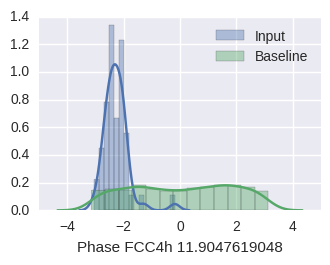

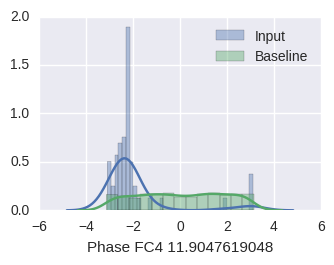

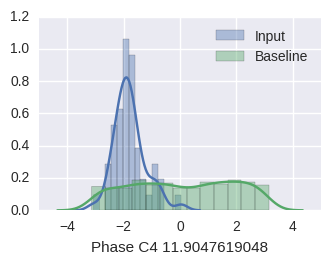

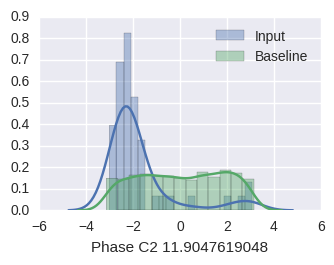

In [56]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

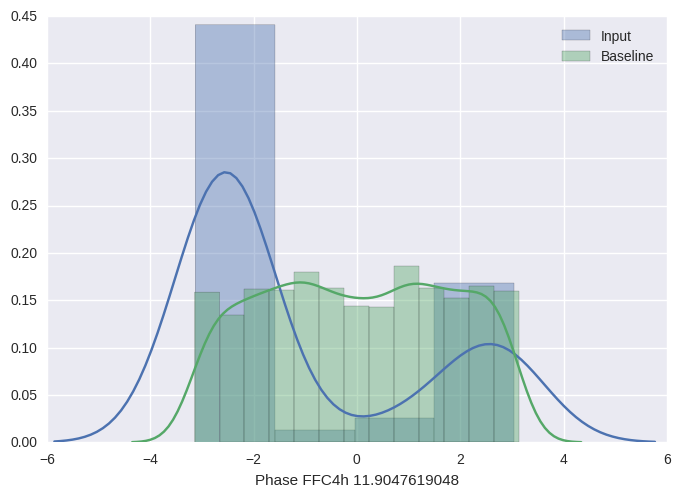

In [57]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window

In [58]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [48, 5]] ['Phase', [38, 5]] ['Phase', [59, 5]]
 ['Phase', [58, 5]] ['Phase', [68, 5]] ['Phase', [28, 5]] ['FFT', [55, 6]]
 ['Phase', [37, 5]] ['Phase', [49, 5]] ['Phase', [47, 5]]]


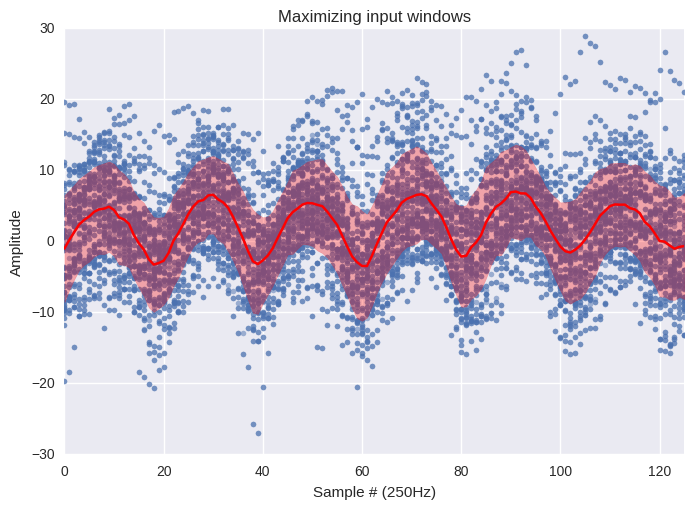

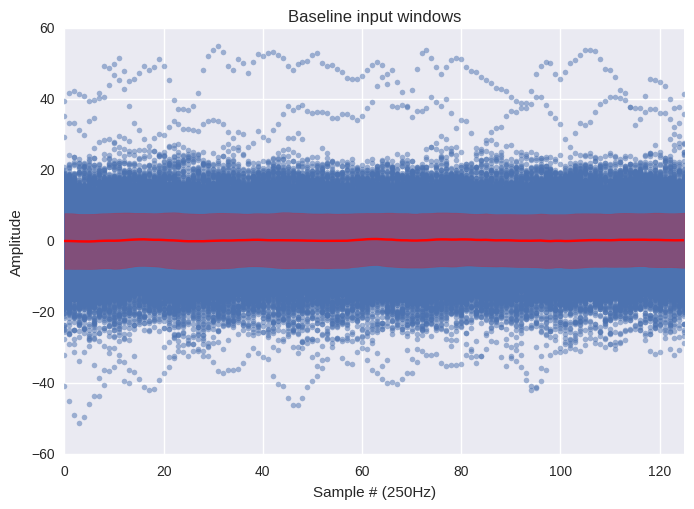

In [59]:
ch = index_labels[sort_mean_diff[:10]][0][1][0]
plot.plot_channel_avg(X_RF_cropped,ch,'Maximizing input windows')
plot.plot_channel_avg(X_baseline,ch,'Baseline input windows')

### FFT Topology Plots
1. Band Power difference
2. Band Power KS Score

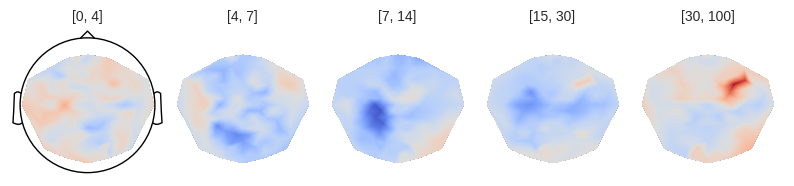

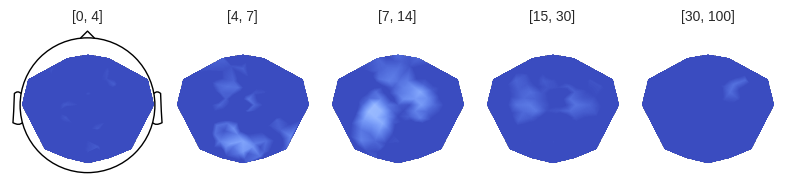

In [65]:
plot.plot_scalp_grid_bands_mean(FFT_bands_diff,sensor_names,freq_bands)
plot.plot_scalp_grid_bands_mean(FFT_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

### Phase Topology Plots
1. Variance phase in band
2. Band Phase KS Score

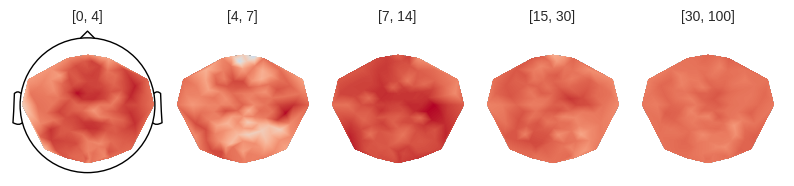

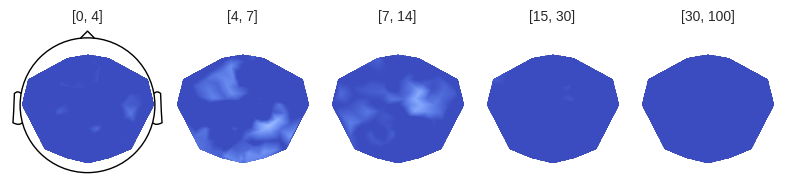

In [66]:
plot.plot_scalp_grid_bands_mean(Phase_bands_class,sensor_names,freq_bands,scale_per_row=True)
plot.plot_scalp_grid_bands_mean(Phase_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

# Layer 22

Analysis of filters in Layer 22

In [50]:
del RF_Result

In [57]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits50_nFilters05'),22,cl)

IOError: [Errno 2] No such file or directory: '/home/hartmank/data/convvisual/RF_data/paper/ours/cnt/deep4/car/22/ClassAnalysis_FilterDiff_nUnits50_nFilters05/Layer22/RF_class_0.data'

### Filter activation

Max filters:  [155  70  85   7 183]


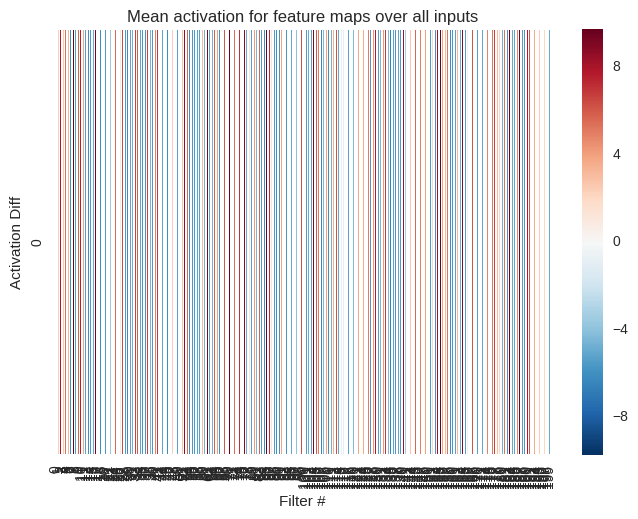

In [52]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [53]:
filt = 0

In [54]:
X_RF_cropped = utils.get_RF(RF_Result,filt,128)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2]

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Power':[sensor_names]})

KeyboardInterrupt: 

In [55]:
FFT_bands_diff,Phase_bands_class,(FFT_KS_bands,Phase_KS_bands) = utils.get_FFT_Phase_band_means_KS_diff(X_baseline,X_RF_cropped,sampling_rate,frequencies,freq_bands)

KeyboardInterrupt: 

### Receptive field starting sample

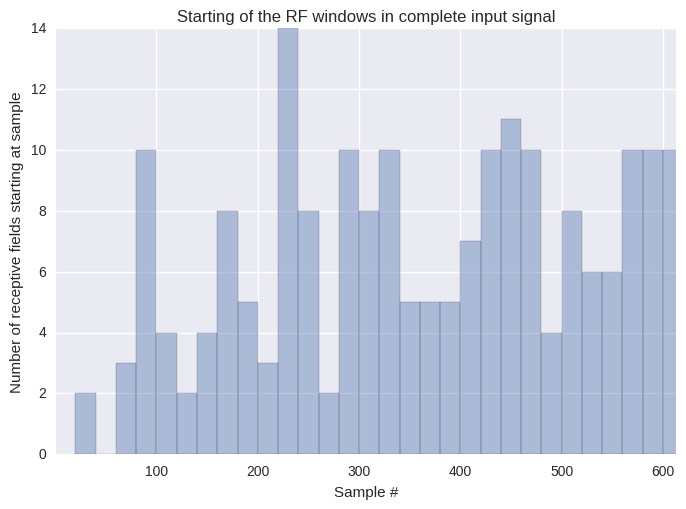

In [68]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Most differentiating Features

In [69]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.488101  p 0.000000  : FFT C3 12.2739018088
Score 0.482570  p 0.000000  : Power C3
Score 0.470447  p 0.000000  : FFT C3 10.9819121447
Score 0.466648  p 0.000000  : FFT C3 11.6279069767
Score 0.464190  p 0.000000  : FFT CCP5h 11.6279069767
Score 0.463464  p 0.000000  : Power C4
Score 0.443743  p 0.000000  : FFT FCC3h 11.6279069767
Score 0.433240  p 0.000000  : FFT FC3 11.6279069767
Score 0.430056  p 0.000000  : Power FCC3h
Score 0.418380  p 0.000000  : Power FCC4h
Score 0.410894  p 0.000000  : FFT CCP5h 10.9819121447
Score 0.410782  p 0.000000  : FFT CCP3h 12.2739018088
Score 0.408324  p 0.000000  : FFT CP3 11.6279069767
Score 0.404581  p 0.000000  : Power CCP5h
Score 0.404246  p 0.000000  : FFT CCP3h 11.6279069767
Score 0.401453  p 0.000000  : FFT CP3 12.2739018088
Score 0.398045  p 0.000000  : FFT C4 9.68992248062
Score 0.394413  p 0.000000  : Power C1
Score 0.393966  p 0.000000  : FFT FC3 18.0878552972
Score 0.392961  p 0.000000  : FFT C4 10.9819121447


##### Feature distributions

(100, 74112) (1790, 74112)


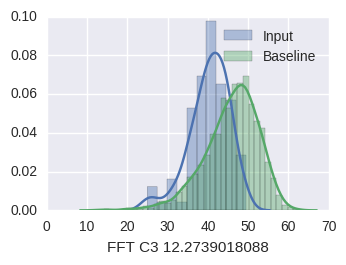

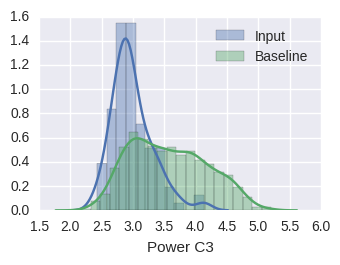

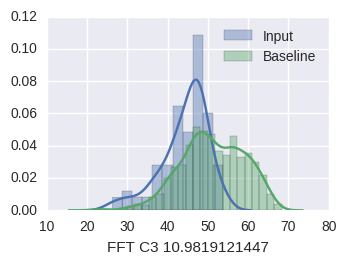

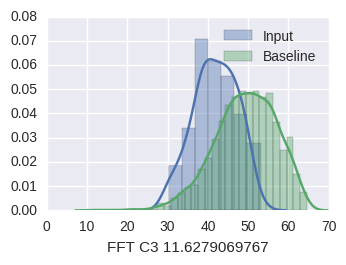

In [70]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

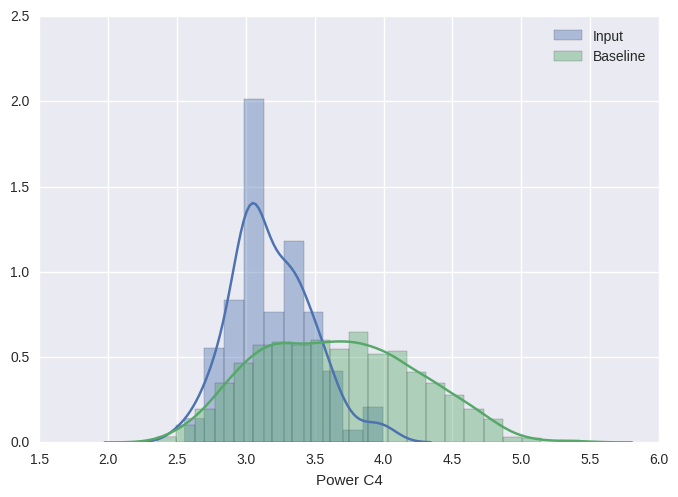

In [71]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window

In [72]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [55, 19]] ['Power', [55]] ['FFT', [55, 17]] ['FFT', [55, 18]]
 ['FFT', [64, 18]] ['Power', [59]] ['FFT', [45, 18]] ['FFT', [34, 18]]
 ['Power', [45]] ['Power', [48]]]


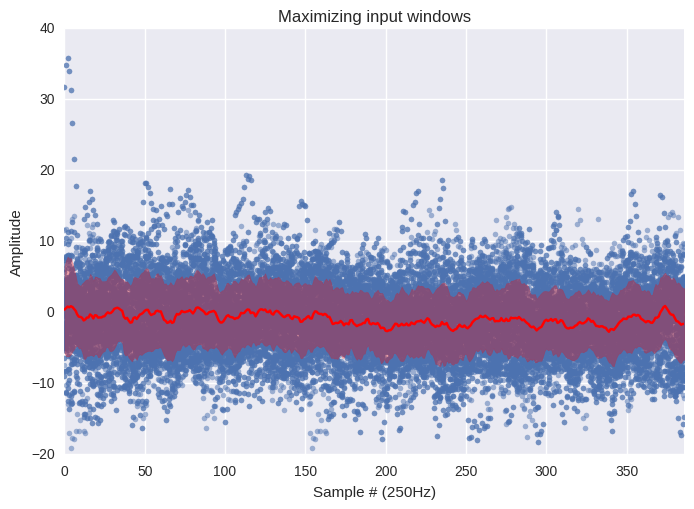

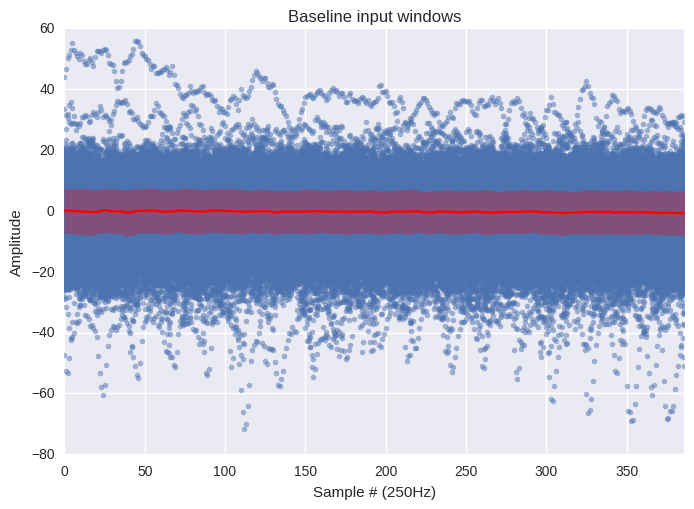

In [73]:
ch = index_labels[sort_mean_diff[:10]][0][1][0]
plot.plot_channel_avg(X_RF_cropped,ch,'Maximizing input windows')
plot.plot_channel_avg(X_baseline,ch,'Baseline input windows')

### FFT Topology Plots
1. Band Power difference
2. Band Power KS Score

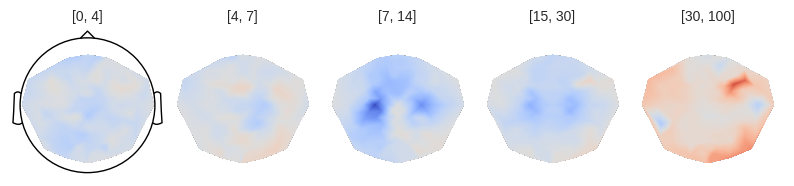

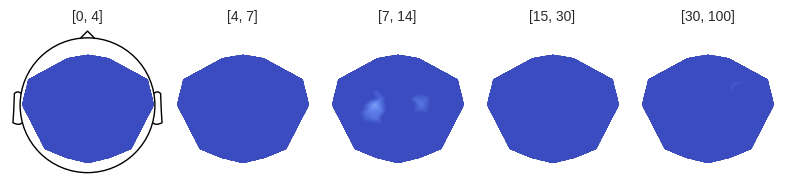

In [74]:
plot.plot_scalp_grid_bands_mean(FFT_bands_diff,sensor_names,freq_bands)
plot.plot_scalp_grid_bands_mean(FFT_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

### Phase Topology Plots
1. Variance phase in band
2. Band Phase KS Score

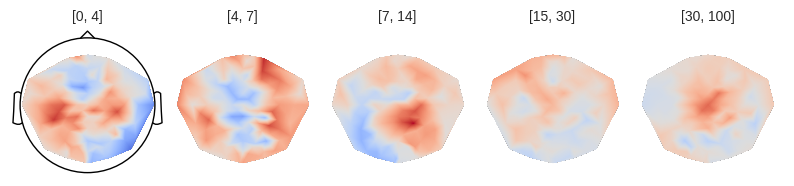

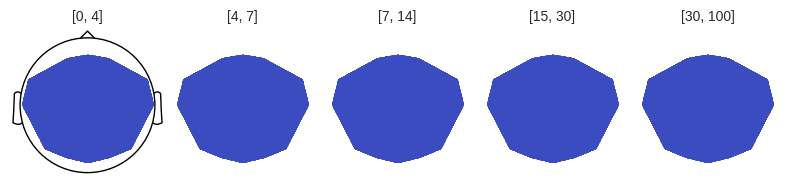

In [75]:
plot.plot_scalp_grid_bands_mean(Phase_bands_class,sensor_names,freq_bands,scale_per_row=True)
plot.plot_scalp_grid_bands_mean(Phase_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

# Layer 28

Analysis of filters in Layer 28

In [76]:
del RF_Result

In [77]:
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits200_nFilters5'),28,cl)

### Filter activation

Max filters:  [0 1 2 3]


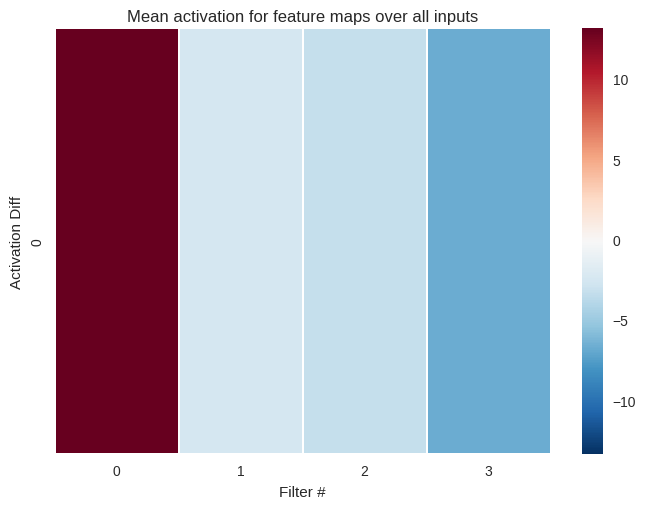

In [78]:
plot.plot_max_filters(RF_Result)

<b>Filter to look at</b> (index in Max filters)

In [79]:
filt = 0

In [80]:
X_RF_cropped = utils.get_RF(RF_Result,filt,128)[:n_class_inputs]
X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]

frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2]

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Power':[sensor_names]})

In [81]:
FFT_bands_diff,Phase_bands_class,(FFT_KS_bands,Phase_KS_bands) = utils.get_FFT_Phase_band_means_KS_diff(X_baseline,X_RF_cropped,sampling_rate,frequencies,freq_bands)

### Receptive field starting sample

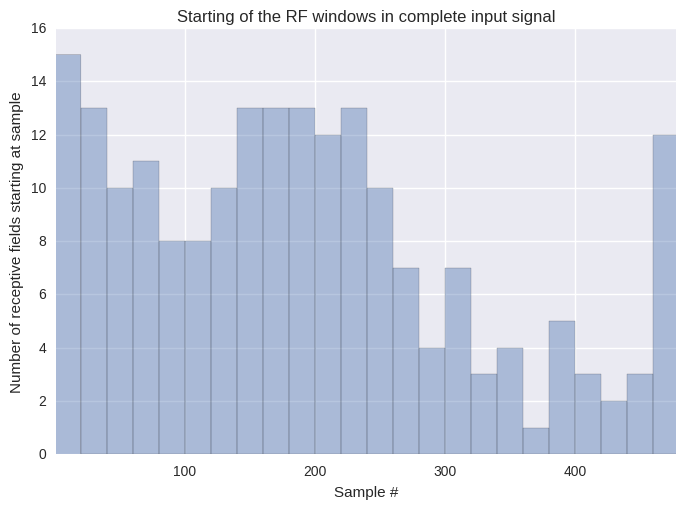

In [82]:
plot.plot_RF_starts(RF_Data,RF_Result,X_baseline.shape[2],filt)

### Most differentiating Features

In [83]:
plot.print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.477318  p 0.000000  : FFT FCC4h 11.9731800766
Score 0.441453  p 0.000000  : FFT CCP3h 11.0153256705
Score 0.420670  p 0.000000  : FFT FFC4h 11.9731800766
Score 0.416927  p 0.000000  : FFT C3 11.0153256705
Score 0.408101  p 0.000000  : FFT CCP5h 11.0153256705
Score 0.399777  p 0.000000  : FFT CP3 11.0153256705
Score 0.395754  p 0.000000  : FFT C3 11.4942528736
Score 0.392011  p 0.000000  : FFT C3 11.9731800766
Score 0.377151  p 0.000000  : FFT FCC3h 11.0153256705
Score 0.375978  p 0.000000  : FFT CP5 11.0153256705
Score 0.375810  p 0.000000  : FFT FCC3h 11.4942528736
Score 0.372235  p 0.000000  : FFT CCP3h 11.4942528736
Score 0.370223  p 0.000000  : FFT FC4 11.9731800766
Score 0.369385  p 0.000000  : Meanc CPP3h
Score 0.368268  p 0.000000  : Power C3
Score 0.365475  p 0.000000  : Meanc P1
Score 0.364804  p 0.000000  : Meanc CP1
Score 0.364022  p 0.000000  : FFT CP3 11.4942528736
Score 0.362402  p 0.000000  : FFT FCC4h 11.4942528736
Score 0.361453  p 0.000000  : FFT FC3 11.015325

##### Feature distributions

(100, 100224) (1790, 100224)


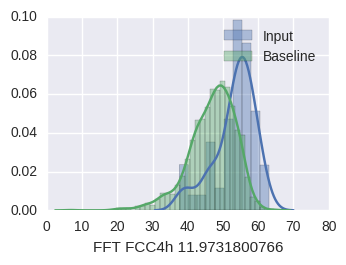

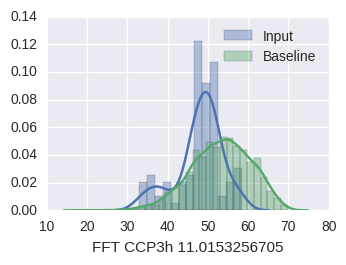

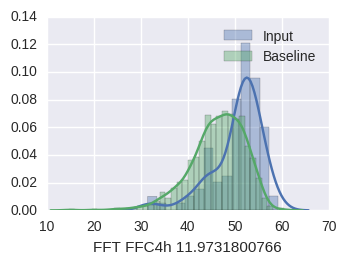

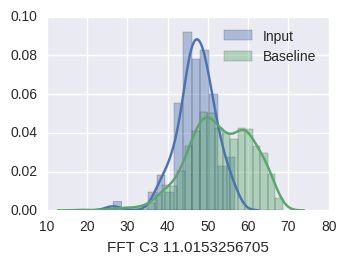

In [84]:
print features_class.shape,features_base.shape
plot.subplots_4_features(features_class,features_base,labels,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

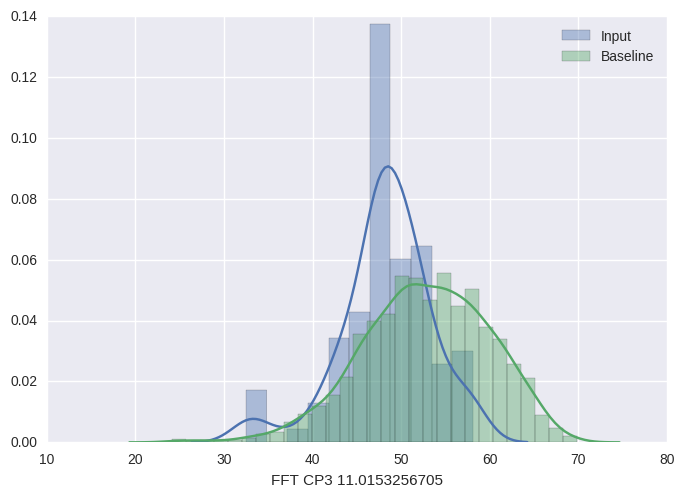

In [85]:
plot.plot_dist_comparison(features_class,features_base,labels,sort_mean_diff[5])

### Average signal window

In [86]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [48, 25]] ['FFT', [65, 23]] ['FFT', [28, 25]] ['FFT', [55, 23]]
 ['FFT', [64, 23]] ['FFT', [73, 23]] ['FFT', [55, 24]] ['FFT', [55, 25]]
 ['FFT', [45, 23]] ['FFT', [72, 23]]]


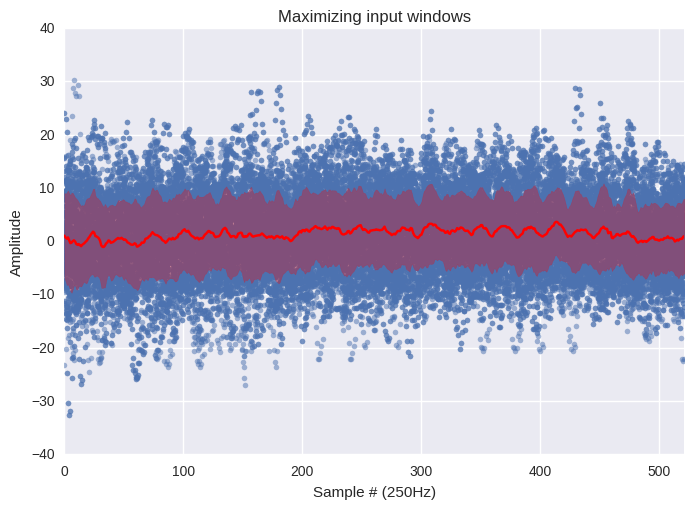

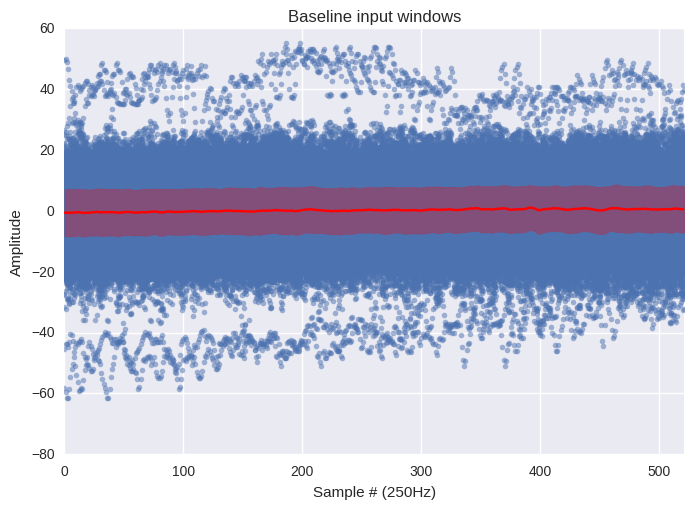

In [87]:
ch = index_labels[sort_mean_diff[:10]][0][1][0]
plot.plot_channel_avg(X_RF_cropped,ch,'Maximizing input windows')
plot.plot_channel_avg(X_baseline,ch,'Baseline input windows')

### FFT Topology Plots
1. Band Power difference
2. Band Power KS Score

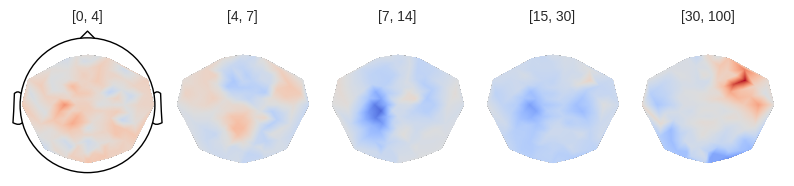

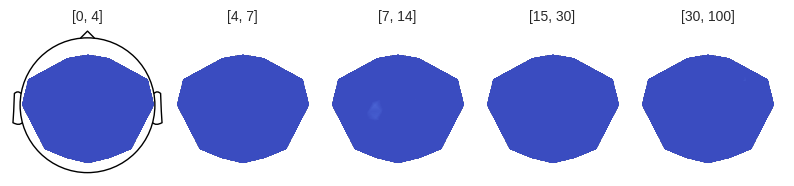

In [88]:
plot.plot_scalp_grid_bands_mean(FFT_bands_diff,sensor_names,freq_bands)
plot.plot_scalp_grid_bands_mean(FFT_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)

### Phase Topology Plots
1. Variance phase in band
2. Band Phase KS Score

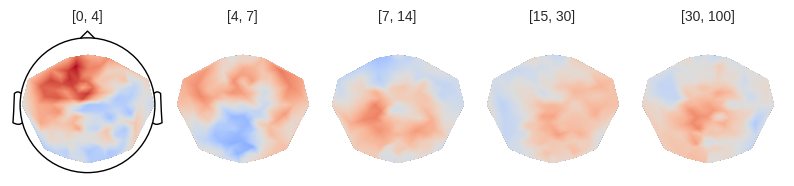

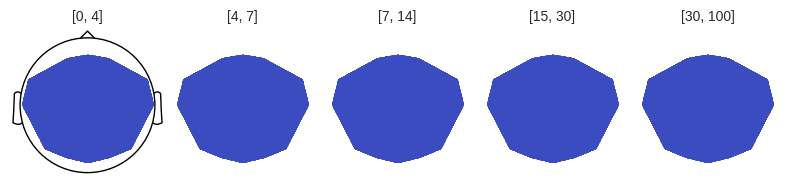

In [89]:
plot.plot_scalp_grid_bands_mean(Phase_bands_class,sensor_names,freq_bands,scale_per_row=True)
plot.plot_scalp_grid_bands_mean(Phase_KS_bands,sensor_names,freq_bands,vmin=0.2,vmax=0.8,scale_per_row=False)